In [5]:
import os
import json
import pickle
import sys
sys.path.insert(0, "../")
sys.path.insert(0, "../../")
from src.DataSaver import DataSaver
from src.DynamicSystemAnalyzer import *
from src.PerformanceAnalyzer import *
from src.RNN_numpy import RNN_numpy
from src.utils import get_project_root, numpify, orthonormalize
from src.Trainer import Trainer
from src.RNN_torch import RNN_torch
from src.PerformanceAnalyzer import PerformanceAnalyzerCDDM
from src.Task import *
from matplotlib import pyplot as plt
import torch
import time
from sklearn.decomposition import IncrementalPCA as iPCA
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, SpectralClustering, DBSCAN
from sklearn.decomposition import TruncatedSVD
from sklearn.mixture import GaussianMixture
np.set_printoptions(suppress = True)
import plotly.express as px
import numpy as np
from matplotlib import pyplot as plt
np.set_printoptions(suppress=True)
import json
from matplotlib import image as mpimg
import torch
from scipy.stats import zscore
from rnn_coach.src.Task import TaskCDDM, TaskCDDMplus
from rnn_coach.src.RNN_torch import RNN_torch
from rnn_coach.src.RNN_numpy import RNN_numpy
from scipy.sparse.linalg import lsqr
from copy import deepcopy
import pandas as pd
import datetime

# Loading all the RNNs into a pandas DataFrame

In [6]:
task_name = "CDDM"
RNNs_path = os.path.join('../', '../', "rnn_coach", "data", "trained_RNNs", task_name)

In [7]:
RNNs = []
for folder in os.listdir(os.path.join('../', "data", "trained_RNNs", task_name)):
    if (folder == '.DS_Store'):
        pass
    else:
        if "relu" in folder:
            RNNs.append(folder)

In [11]:
names = []
scores = []
Ns = []
lmbdos = []
lmbdrs = []
lrs = []
activations = []
tags = []
maxiters = []
dates = []
for folder in RNNs:
    day = datetime.datetime.fromtimestamp(os.path.getmtime(os.path.join(RNNs_path, folder))).strftime('%d')
    month = datetime.datetime.fromtimestamp(os.path.getmtime(os.path.join(RNNs_path, folder))).strftime('%m')
    year = datetime.datetime.fromtimestamp(os.path.getmtime(os.path.join(RNNs_path, folder))).strftime('%Y')
    if (float(month) >= 6) and (float(day) >=20):
        files = os.listdir(os.path.join(RNNs_path, folder))
        config_file = None
        for file in files:
            if "config" in file:
                config_file = file
        config_data = json.load(open(os.path.join(RNNs_path, folder, config_file), "rb+"))
        score = np.round(float(config_file.split("_")[0]), 7)
        activation = config_data["activation"]
        N = config_data["N"]
        lmbdo = config_data["lambda_orth"]
        lmbdr = config_data["lambda_r"]
        lr=config_data["lr"]
        maxiter=config_data["max_iter"]
        extra_info = f"{task_name};{activation};N={N};lmbdo={lmbdo};lmbdr={lmbdr};lr={lr};maxiter={maxiter}"
        name = f"{score}_{extra_info}"
        tag = config_data["tag"]
        names.append(name)
        scores.append(score)
        Ns.append(N)
        lmbdos.append(lmbdo)
        lmbdrs.append(lmbdr)
        lrs.append(lr)
        tags.append(tag)
        activations.append(activation)
        maxiters.append(maxiter)
        dates.append(f"{day}/{month}/{year}")

In [12]:
df = pd.DataFrame({"name" : names, "scores" : scores, "N" : Ns, "date": dates, "activation": activations, "lmbdo" : lmbdos, "lmbdr": lmbdrs, "lr" : lrs, "maxiter" : maxiters})

In [14]:
# additional filtering
# df = df[df['lr'] == 0.005]
df = df[df['maxiter'] == 3000]

In [15]:
pd.set_option('display.max_rows', None)
df.sort_values("scores")

,name,scores,N,date,activation,lmbdo,lmbdr,lr,maxiter
28,0.0077175_CDDM;relu;N=97;lmbdo=0.3;lmbdr=0.3;l...,0.007718,97,22/06/2023,relu,0.3,0.3,0.002,3000
95,0.0078732_CDDM;relu;N=98;lmbdo=0.3;lmbdr=0.3;l...,0.007873,98,22/06/2023,relu,0.3,0.3,0.002,3000
38,0.0079036_CDDM;relu;N=98;lmbdo=0.3;lmbdr=0.3;l...,0.007904,98,22/06/2023,relu,0.3,0.3,0.002,3000
67,0.0079341_CDDM;relu;N=96;lmbdo=0.3;lmbdr=0.3;l...,0.007934,96,22/06/2023,relu,0.3,0.3,0.002,3000
26,0.0079439_CDDM;relu;N=96;lmbdo=0.3;lmbdr=0.3;l...,0.007944,96,22/06/2023,relu,0.3,0.3,0.002,3000
72,0.0079477_CDDM;relu;N=97;lmbdo=0.3;lmbdr=0.3;l...,0.007948,97,22/06/2023,relu,0.3,0.3,0.002,3000
4,0.0079531_CDDM;relu;N=100;lmbdo=0.3;lmbdr=0.3;...,0.007953,100,22/06/2023,relu,0.3,0.3,0.002,3000
69,0.0079612_CDDM;relu;N=94;lmbdo=0.3;lmbdr=0.3;l...,0.007961,94,22/06/2023,relu,0.3,0.3,0.002,3000
22,0.0079655_CDDM;relu;N=96;lmbdo=0.3;lmbdr=0.3;l...,0.007966,96,22/06/2023,relu,0.3,0.3,0.002,3000
46,0.0079709_CDDM;relu;N=98;lmbdo=0.3;lmbdr=0.3;l...,0.007971,98,22/06/2023,relu,0.3,0.3,0.002,3000


In [16]:
top_RNNs = df.sort_values("scores")["name"].tolist()

In [17]:
top_RNNs

['0.0077175_CDDM;relu;N=97;lmbdo=0.3;lmbdr=0.3;lr=0.002;maxiter=3000',
 '0.0078732_CDDM;relu;N=98;lmbdo=0.3;lmbdr=0.3;lr=0.002;maxiter=3000',
 '0.0079036_CDDM;relu;N=98;lmbdo=0.3;lmbdr=0.3;lr=0.002;maxiter=3000',
 '0.0079341_CDDM;relu;N=96;lmbdo=0.3;lmbdr=0.3;lr=0.002;maxiter=3000',
 '0.0079439_CDDM;relu;N=96;lmbdo=0.3;lmbdr=0.3;lr=0.002;maxiter=3000',
 '0.0079477_CDDM;relu;N=97;lmbdo=0.3;lmbdr=0.3;lr=0.002;maxiter=3000',
 '0.0079531_CDDM;relu;N=100;lmbdo=0.3;lmbdr=0.3;lr=0.002;maxiter=3000',
 '0.0079612_CDDM;relu;N=94;lmbdo=0.3;lmbdr=0.3;lr=0.002;maxiter=3000',
 '0.0079655_CDDM;relu;N=96;lmbdo=0.3;lmbdr=0.3;lr=0.002;maxiter=3000',
 '0.0079709_CDDM;relu;N=98;lmbdo=0.3;lmbdr=0.3;lr=0.002;maxiter=3000',
 '0.0079841_CDDM;relu;N=98;lmbdo=0.3;lmbdr=0.3;lr=0.002;maxiter=3000',
 '0.0079912_CDDM;relu;N=99;lmbdo=0.3;lmbdr=0.3;lr=0.002;maxiter=3000',
 '0.0079937_CDDM;relu;N=95;lmbdo=0.3;lmbdr=0.3;lr=0.002;maxiter=3000',
 '0.0080035_CDDM;relu;N=96;lmbdo=0.3;lmbdr=0.3;lr=0.002;maxiter=3000',
 '0.0

# Getting a specific RNN out of the DataGrame

In [9]:
num_rnn = 0
RNN_subfolder = top_RNNs[num_rnn]
RNN_score = float(top_RNNs[num_rnn].split("_")[0])
RNN_path = os.path.join('../', '../', "rnn_coach", "data", "trained_RNNs", task_name, RNN_subfolder)
os.listdir(RNN_path)

['0.0064935_fp_data.json',
 '0.0064935_LA_RHS.png',
 '0.0064935_LA_3D.png',
 '0.0064935_params_CDDM.json',
 '0.0064935_psychometric_data.png',
 '0.0064935_train&valid_loss.png',
 '0.0064935_LA_data.pkl',
 '0.0064935_config.json',
 '0.0064935_random_trials.png',
 '0.0064935_psycho_data.json']

In [10]:
RNN_data = json.load(open(os.path.join(RNN_path, f"{RNN_score}_params_{task_name}.json"), "rb+"))
RNN_config_file = json.load(open(os.path.join(RNN_path, f"{RNN_score}_config.json"), "rb+"))

In [11]:
seed = np.random.randint(1000000)
print(f"seed: {seed}")
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
rng = torch.Generator(device=torch.device(device))
if not seed is None:
    rng.manual_seed(seed)

if activation == 'relu':
    activation_RNN = lambda x: torch.maximum(x, torch.tensor(0))
elif activation == 'tanh':
    activation_RNN = torch.tanh
elif activation == 'sigmoid':
    activation_RNN = lambda x: 1/(1 + torch.exp(-x))
elif activation == 'softplus':
    activation_RNN = lambda x: torch.log(1 + torch.exp(5 * x))

seed: 177755


In [12]:
N = RNN_data["N"]
W_out = np.array(RNN_data["W_out"])
W_rec = np.array(RNN_data["W_rec"])
W_inp = np.array(RNN_data["W_inp"])
bias_rec = np.array(RNN_data["bias_rec"])
y_init = np.array(RNN_data["y_init"])
activation = RNN_config_file["activation"]
mask = np.array(RNN_config_file["mask"])
input_size = RNN_config_file["num_inputs"]
output_size = RNN_config_file["num_outputs"]
task_params = RNN_config_file["task_params"]
n_steps = task_params["n_steps"]
sigma_inp = RNN_config_file["sigma_inp"]
sigma_rec = RNN_config_file["sigma_rec"]
dt = RNN_config_file["dt"]
tau = RNN_config_file["tau"]

In [13]:
task_params["coherences"] = [-0.8, -0.4, -0.2, -0.1, 0, 0.1, 0.2, 0.4, 0.8]

In [14]:
task = TaskCDDM(n_steps=n_steps, n_inputs=input_size, n_outputs=output_size, task_params=task_params)
input_batch, target_batch, conditions_batch = task.get_batch()
n_trials = len(conditions_batch)

In [15]:
RNN_np = RNN_numpy(N=N,
                  dt=dt,
                  tau=tau,
                  activation=lambda x: np.maximum(0, x),
                  W_inp=W_inp,
                  W_rec=W_rec,
                  W_out=W_out,
                  bias_rec=np.zeros(N),
                  y_init=y_init)

In [16]:
analyzer = PerformanceAnalyzerCDDM(RNN_np)
score_function = lambda x, y: np.mean((x - y) ** 2)
input_batch_valid, target_batch_valid, conditions_valid = task.get_batch()
score = analyzer.get_validation_score(score_function, input_batch_valid, target_batch_valid,
                                      mask, sigma_rec=sigma_rec, sigma_inp=sigma_inp)

In [17]:
print(f"MSE validation: {np.round(score, 5)}")

MSE validation: 0.04481


Plotting random trials


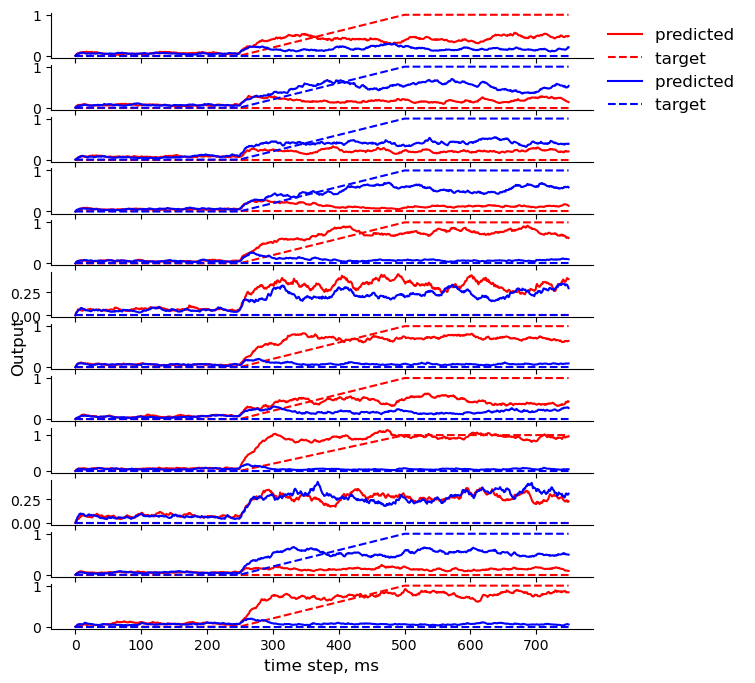

In [18]:
print(f"Plotting random trials")
inds = np.random.choice(np.arange(input_batch_valid.shape[-1]), 12)
inputs = input_batch[..., inds]
targets = target_batch[..., inds]

fig_trials = analyzer.plot_trials(inputs, targets, mask, sigma_rec=sigma_rec, sigma_inp=sigma_inp)
plt.show()

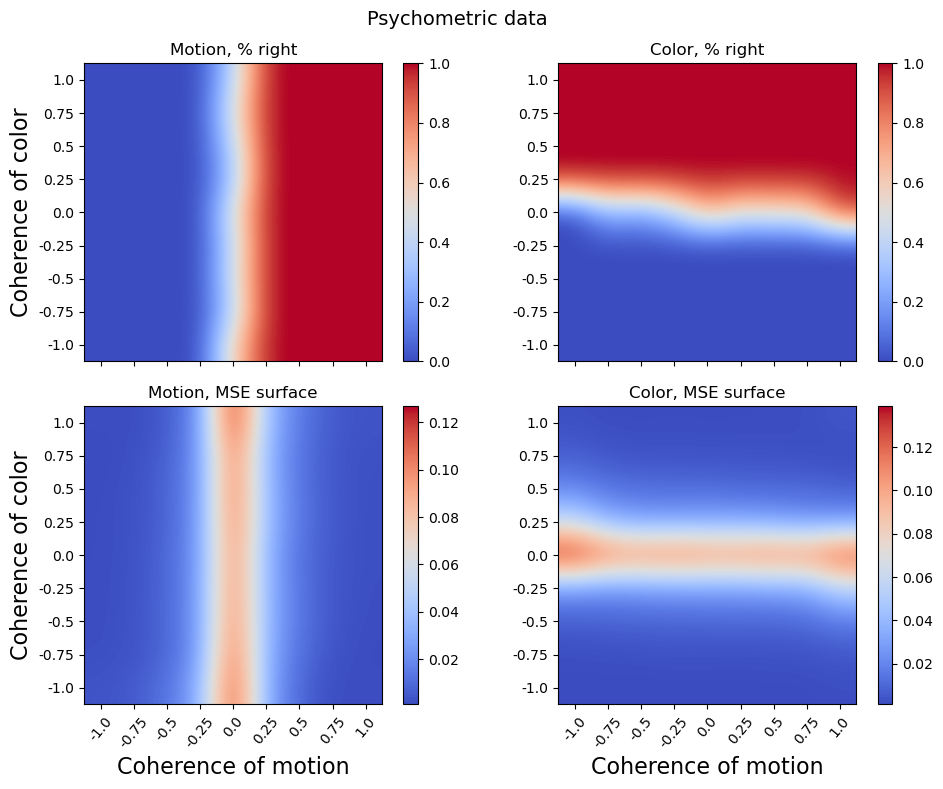

In [19]:
num_levels = len(task_params["coherences"])
analyzer.calc_psychometric_data(task, mask, num_levels=num_levels, num_repeats=31, sigma_rec=0.03, sigma_inp=0.03)
fig_psycho = analyzer.plot_psychometric_data()
plt.show()

In [20]:
dsa = DynamicSystemAnalyzerCDDM(RNN_np)
params = {"fun_tol" : 0.05,
          "diff_cutoff":1e-4,
          "sigma_init_guess":10,
          "patience":10,
          "stop_length":10,
          "mode":"approx"}
dsa.calc_LineAttractor_analytics()

Analyzing points on a line attractor in motion context...


  0%|          | 0/31 [00:00<?, ?it/s]

Analyzing points on a line attractor in color context...


  0%|          | 0/31 [00:00<?, ?it/s]

In [21]:
choice_axis = RNN_np.W_out.flatten() if RNN_np.W_out.shape[0] == 1 else (RNN_np.W_out[0, :] - RNN_np.W_out[1, :])
context_axis = RNN_np.W_inp[:, 0] - RNN_np.W_inp[:, 1]
sensory_axis = np.sum([RNN_np.W_inp[:, i] for i in [2, 3, 4, 5]])

P_matrix = np.zeros((RNN_np.N, 3))
P_matrix[:, 0] = choice_axis
P_matrix[:, 1] = context_axis
P_matrix[:, 2] = sensory_axis

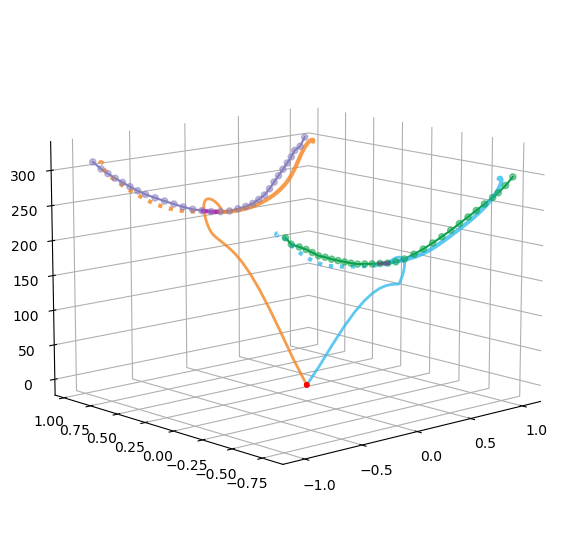

In [22]:
fig_LA = dsa.plot_LineAttractor_3D()
plt.show()

In [23]:
# dsa.get_fixed_points(Input=np.array([1, 0, 0.5, 0.5, 0.5, 0.5]), **params)
# dsa.get_fixed_points(Input=np.array([0, 1, 0.5, 0.5, 0.5, 0.5]), **params)

In [24]:
# fig_fp = dsa.plot_fixed_points(projection='3D', P=P_matrix)
# plt.xlabel("Output axis", fontsize=16)
# plt.show()

# Decoding the axes

In [25]:
RNN = RNN_torch(N=W_rec.shape[0], dt=dt, tau=tau, input_size=input_size, output_size=output_size,
                activation=activation_RNN, random_generator=rng, device=device,
                sigma_rec=sigma_rec, sigma_inp=sigma_inp)
RNN_params = {"W_inp": W_inp,
              "W_rec": W_rec,
              "W_out": W_out,
              "b_rec": None,
              "y_init": np.zeros(W_rec.shape[0])}
RNN.set_params(RNN_params)

Using cpu for RNN!


In [28]:
# RNN_train.sigma_rec = RNN_train.sigma_inp = torch.tensor(0, device=RNN_train.device)
y_train, predicted_output_rnn_train = RNN(torch.from_numpy(input_batch.astype("float32")))
Y_train = np.hstack([y_train.detach().numpy()[:, :, i] for i in range(y_train.shape[-1])])
y_valid, predicted_output_rnn_valid = RNN(torch.from_numpy(input_batch.astype("float32")))
Y_valid = np.hstack([y_valid.detach().numpy()[:, :, i] for i in range(y_valid.shape[-1])])

RNN.sigma_rec = RNN.sigma_inp = torch.tensor(0, device=RNN.device)
y_noiseless, predicted_output_rnn_noiseless = RNN(torch.from_numpy(input_batch.astype("float32")))
Y_noiseless = np.hstack([y_noiseless.detach().numpy()[:, :, i] for i in range(y_noiseless.shape[-1])])

T_inp = np.hstack([input_batch[:, :, i] for i in range(input_batch.shape[-1])])
T_out = np.hstack([target_batch[:, :, i] for i in range(target_batch.shape[-1])])
T_out_masked = np.hstack([target_batch[:, mask, i] for i in range(target_batch.shape[-1])])
T_combined = np.vstack([T_inp, T_out])

traces_train = np.swapaxes(np.swapaxes(y_train.detach().numpy(), 0, -1), 1, -1)
traces_valid = np.swapaxes(np.swapaxes(y_valid.detach().numpy(), 0, -1), 1, -1)
traces_noiseless = np.swapaxes(np.swapaxes(y_noiseless.detach().numpy(), 0, -1), 1, -1)

Z = zscore(Y_train, axis = 1)
z = Z.reshape(-1, n_trials, n_steps)
z = np.swapaxes(z, 1, 2)

In [29]:
# PCA on Z
pca = PCA(n_components=20)
pca.fit(Z.T)
PCs = pca.components_
D = PCs.T @ PCs
Z_pca = D @ Z
z_pca = Z_pca.reshape(-1, n_trials, n_steps)
z_pca = np.swapaxes(z_pca, 1, 2)

Z_valid = zscore(Y_valid, axis = 1)
z_valid = Z_valid.reshape(-1, n_trials, n_steps)
z_valid = np.swapaxes(z_valid, 1, 2)

# PCA on Z
Z_pca_valid = D @ Z_valid
z_pca_valid = Z_pca_valid.reshape(-1, n_trials, n_steps)
z_pca_valid = np.swapaxes(z_pca_valid, 1, 2)

In [30]:
choice = np.array([conditions_batch[i]['correct_choice'] for i in range(len(conditions_batch))])
motion_coh = np.array([conditions_batch[i]['motion_coh'] for i in range(len(conditions_batch))])
color_coh = np.array([conditions_batch[i]['color_coh'] for i in range(len(conditions_batch))])
context = np.array([(1 if conditions_batch[i]['context']=='motion' else -1) for i in range(len(conditions_batch))])
F = np.hstack([context.reshape(-1, 1),
               motion_coh.reshape(-1, 1),
               color_coh.reshape(-1, 1),
               choice.reshape(-1, 1),
               np.ones((n_trials, 1))])

In [31]:
regularization = 100Q
B_tdr = np.zeros((Z.shape[0], n_steps, F.shape[1]))

for i in range(Z.shape[0]):
    for t in range(n_steps):
        betas_i_t = lsqr(F, z_pca[i, t, :], damp=regularization)[0]
        B_tdr[i, t, :] = deepcopy(betas_i_t)
        
ind_cont = np.argmax(np.linalg.norm(B_tdr[:, :, 0], axis=0)[:250])
ind_motion = np.argmax(np.linalg.norm(B_tdr[:, :, 1], axis=0))
ind_color = np.argmax(np.linalg.norm(B_tdr[:, :, 2], axis=0))
ind_choice = np.argmax(np.linalg.norm(B_tdr[:, :, 3], axis=0))

context_direction = B_tdr[:, ind_cont, 0]/np.linalg.norm(B_tdr[:, ind_cont, 0])
motion_direction = B_tdr[:, ind_motion, 1]/np.linalg.norm(B_tdr[:, ind_motion, 1])
color_direction = B_tdr[:, ind_color, 2]/np.linalg.norm(B_tdr[:, ind_color, 2])
choice_direction = B_tdr[:, ind_choice, 3]/np.linalg.norm(B_tdr[:, ind_choice, 3])

B_tdr_max = np.hstack([choice_direction.reshape(-1, 1),
                   motion_direction.reshape(-1, 1),
                   color_direction.reshape(-1, 1),
                   context_direction.reshape(-1,1)])

In [32]:
labels = ["choice", "motion", "color", "context"]
B_tdr_orth, R = np.linalg.qr(B_tdr_max)
Decoded_vars_B = np.einsum("ij,kit->kjt", B_tdr_orth, traces_valid)

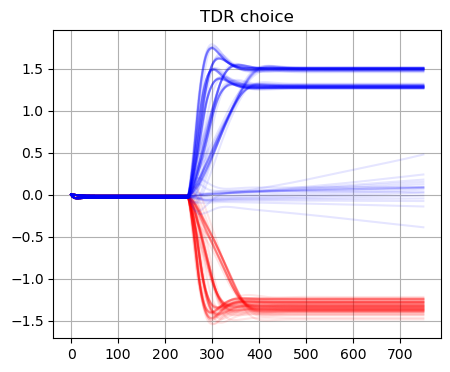

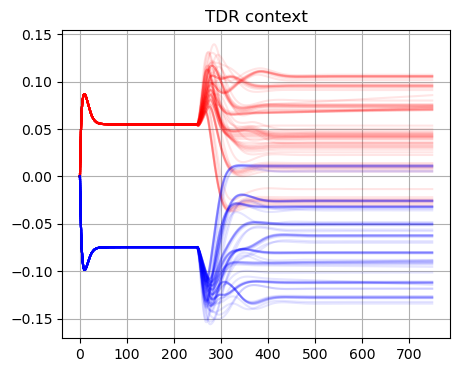

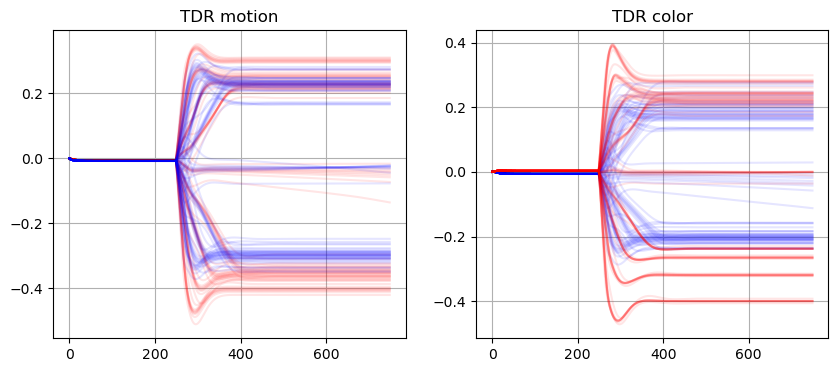

In [36]:
num_trials = Decoded_vars_B.shape[0]
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
choices = np.array([conditions_batch[i]["correct_choice"] for i in range(len(conditions_batch))])
ind_right_choice = np.where(choices == 1)[0]
ind_left_choice = np.where(choices == -1)[0]

ax.plot(Decoded_vars_B[ind_right_choice, labels.index("choice"), :].T, color='r', alpha=0.1, label = 'choice to right')
ax.plot(Decoded_vars_B[ind_left_choice, labels.index("choice"), :].T, color='b', alpha=0.1, label = 'choice to left')
# plt.tight_layout()
plt.subplots_adjust(hspace=0.2)
ax.title.set_text('TDR choice')
ax.grid(True)
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
choices = np.array([conditions_batch[i]["correct_choice"] for i in range(len(conditions_batch))])
ind_right_choice = np.where(choices == 1)[0]
ind_left_choice = np.where(choices == -1)[0]

ax.plot(Decoded_vars_B[:num_trials//2, labels.index("context"), :].T, color='r', alpha=0.1, label = 'context')
ax.plot(Decoded_vars_B[num_trials//2:, labels.index("context"), :].T, color='b', alpha=0.1, label = 'context')
# plt.tight_layout()
plt.subplots_adjust(hspace=0.2)
ax.title.set_text('TDR context')
ax.grid(True)
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(Decoded_vars_B[:num_trials//2, labels.index("motion"), :].T, color='r', alpha=0.1, label = 'relevant')
ax[0].plot(Decoded_vars_B[num_trials//2:, labels.index("motion"), :].T, color='b', alpha=0.1, label = 'irrelevant')
# ax[0].set_ylim([-15, 15])
ax[1].plot(Decoded_vars_B[:num_trials//2, labels.index("color"), :].T, color='b', alpha=0.1)
ax[1].plot(Decoded_vars_B[num_trials//2:, labels.index("color"), :].T, color='r', alpha=0.1)

# plt.tight_layout()
plt.subplots_adjust(hspace=0.2)
ax[0].title.set_text('TDR motion')
ax[1].title.set_text('TDR color')
ax[0].grid(True)
ax[1].grid(True)
plt.show()